# Ajuste de distribuciones para las características más relevantes (Punto 1)

Este cuaderno carga el conjunto de datos etiquetado, identifica las tres características con mayor información mutua respecto a la variable objetivo y ajusta automáticamente varias distribuciones continuas a cada una de esas características. Para cada variable se selecciona el mejor ajuste según el criterio de información de Akaike (AIC) y se muestran los parámetros estimados.

## Preparar dependencias

Importamos las bibliotecas clave para explorar los datos, estimar distribuciones y cuantificar la relevancia de cada variable frente a `Target`.

In [46]:
import warnings

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

## Cargar y limpiar los datos

Leemos el archivo CSV con separador `;`, normalizamos los nombres de columnas y revisamos una vista previa para confirmar la estructura.

In [47]:
DATA_PATH = "data/data.csv"

df = pd.read_csv(DATA_PATH, sep=";", decimal=".", encoding="utf-8-sig")
df.columns = (
    df.columns.str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .str.replace('"', "")
)

df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Identificar columnas numéricas

Convertimos todas las columnas posibles a valores numéricos, separamos la variable objetivo `Target` y contamos cuántas características quedan disponibles.

In [48]:
numeric_df = df.copy()
for col in numeric_df.columns:
    numeric_df[col] = pd.to_numeric(numeric_df[col], errors="ignore")

target_col = "Target"
feature_cols = [col for col in numeric_df.columns if col != target_col]
numeric_cols = numeric_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Total de observaciones: {len(df)}")
print(f"Características numéricas disponibles: {len(numeric_cols)}")

Total de observaciones: 4424
Características numéricas disponibles: 36


## Seleccionar las tres características más informativas

Imputamos ausencias con la mediana, codificamos `Target` de forma numérica y calculamos información mutua para quedarnos con las tres variables más predictivas.

In [49]:
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(numeric_df[numeric_cols])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df[target_col])

mi = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi, index=numeric_cols).sort_values(ascending=False)
top_features = mi_series.head(3)

top_features.to_frame(name="informacion_mutua")

,informacion_mutua
Curricular units 2nd sem (approved),0.310207
Curricular units 2nd sem (grade),0.239324
Curricular units 1st sem (approved),0.233439


## Definir catálogo de distribuciones (Punto 2)

Declaramos las distribuciones candidatas de SciPy junto con los parámetros y restricciones de soporte necesarios para el ajuste.

In [50]:
candidate_distributions = {
    "norm": stats.norm,
    "lognorm": stats.lognorm,
    "expon": stats.expon,
    "gamma": stats.gamma,
    "weibull_min": stats.weibull_min,
    "weibull_max": stats.weibull_max,
}
positive_support = {"lognorm", "gamma", "weibull_min", "weibull_max"}

param_names = {
    "norm": ("loc", "scale"),
    "lognorm": ("shape", "loc", "scale"),
    "expon": ("loc", "scale"),
    "gamma": ("shape", "loc", "scale"),
    "weibull_min": ("c", "loc", "scale"),
    "weibull_max": ("c", "loc", "scale"),
}

def fit_best_distribution(series):
    data = series.dropna().astype(float).values
    if data.size < 5:
        return {"distribution": None, "params": None, "aic": np.inf}
    results = []
    for name, dist in candidate_distributions.items():
        if name in positive_support and np.any(data <= 0):
            continue
        try:
            params = dist.fit(data)
            loglik = np.sum(dist.logpdf(data, *params))
            k = len(params)
            aic = 2 * k - 2 * loglik
            results.append({"distribution": name, "params": params, "aic": aic})
        except Exception:
            continue
    if not results:
        return {"distribution": None, "params": None, "aic": np.inf}
    return min(results, key=lambda item: item["aic"])

def describe_params(dist_name, params):
    if not dist_name or params is None:
        return "-"
    names = param_names.get(dist_name, tuple(f"p{i}" for i in range(len(params))))
    return ", ".join(f"{name}={value:.4f}" for name, value in zip(names, params))

## Ajustar y resumir resultados

Ajustamos cada característica con todas las distribuciones candidatas, escogemos la de menor AIC y generamos una tabla con los parámetros estimados.

In [51]:
summary_rows = []
for feature in top_features.index:
    result = fit_best_distribution(numeric_df[feature])
    summary_rows.append(
        {
            "variable": feature,
            "mejor_distribucion": result["distribution"] or "Sin ajuste",
            "parametros_estimados": describe_params(result["distribution"], result["params"]),
            "aic": result["aic"],
        }
    )

summary_df = pd.DataFrame(summary_rows).sort_values("aic")
summary_df

,variable,mejor_distribucion,parametros_estimados,aic
0,Curricular units 2nd sem (approved),expon,"loc=0.0000, scale=4.4358",22032.945610
2,Curricular units 1st sem (approved),norm,"loc=4.7066, scale=3.0939",22551.952687
1,Curricular units 2nd sem (grade),norm,"loc=10.2302, scale=5.2102",27163.470613


## Varianzas teóricas y matrices de covarianza

Recalculamos los ajustes para las tres características seleccionadas, extraemos sus medias y varianzas teóricas y construimos la matriz de covarianza teórica asumiendo independencia entre ellas. También obtenemos la matriz de covarianza muestral imputando valores faltantes con la mediana para garantizar comparabilidad.

In [52]:
fit_results = {feature: fit_best_distribution(numeric_df[feature]) for feature in top_features.index}

theoretical_stats = []
means = {}
variances = {}
for feature, result in fit_results.items():
    dist_name = result["distribution"]
    params = result["params"]
    if dist_name is None or params is None:
        theoretical_stats.append({
            "variable": feature,
            "dist": "Sin ajuste",
            "media_teorica": np.nan,
            "varianza_teorica": np.nan,
        })
        continue
    dist = candidate_distributions[dist_name]
    mean, var = dist.stats(*params, moments="mv")
    mean = float(mean)
    var = float(var)
    means[feature] = mean
    variances[feature] = var
    theoretical_stats.append({
        "variable": feature,
        "dist": dist_name,
        "media_teorica": mean,
        "varianza_teorica": var,
    })

theoretical_stats_df = pd.DataFrame(theoretical_stats)
theoretical_cov = pd.DataFrame(
    np.zeros((len(top_features), len(top_features))),
    index=top_features.index,
    columns=top_features.index,
)
for feature, var in variances.items():
    theoretical_cov.loc[feature, feature] = var

X_full = pd.DataFrame(
    imputer.transform(numeric_df[numeric_cols]),
    columns=numeric_cols,
)
selected_sample = X_full[top_features.index]
sample_cov = selected_sample.cov()

cov_diff = sample_cov - theoretical_cov

theoretical_stats_df, theoretical_cov, sample_cov, cov_diff

(                              variable   dist  media_teorica  varianza_teorica
 0  Curricular units 2nd sem (approved)  expon       4.435805         19.676363
 1     Curricular units 2nd sem (grade)   norm      10.230206         27.146382
 2  Curricular units 1st sem (approved)   norm       4.706600          9.572145,
                                      Curricular units 2nd sem (approved)  \
 Curricular units 2nd sem (approved)                            19.676363   
 Curricular units 2nd sem (grade)                                0.000000   
 Curricular units 1st sem (approved)                             0.000000   
 
                                      Curricular units 2nd sem (grade)  \
 Curricular units 2nd sem (approved)                          0.000000   
 Curricular units 2nd sem (grade)                            27.146382   
 Curricular units 1st sem (approved)                          0.000000   
 
                                      Curricular units 1st sem (approve

## Evaluar independencia entre pares de variables (Punto 3)

Usamos las mismas características seleccionadas para contrastar independencia bajo dos criterios: pruebas de independencia de chi-cuadrado sobre la tabla de contingencia discretizada y correlación de Spearman como medida no paramétrica de dependencia monotónica.

Para cada pareja se discretiza a cuartiles (igual número de bins) a fin de construir la tabla de contingencia, se calcula el valor-p de la prueba y se compara contra un nivel de significancia del 5%. Asimismo se reporta el coeficiente de Spearman y su valor-p.

In [53]:
from itertools import combinations
from scipy.stats import chi2_contingency, spearmanr

alpha = 0.05
tests_summary = []

# Trabajamos con los datos imputados para evitar pérdidas por NaNs
selected_sample = X_full[top_features.index]

for feature_x, feature_y in combinations(top_features.index, 2):
    x = selected_sample[feature_x]
    y = selected_sample[feature_y]
    # Discretización en cuartiles para construir tabla de contingencia
    x_bins = pd.qcut(x, q=4, duplicates="drop")
    y_bins = pd.qcut(y, q=4, duplicates="drop")
    contingency = pd.crosstab(x_bins, y_bins)
    chi2, chi_p, dof, expected = chi2_contingency(contingency)
    spearman_coef, spearman_p = spearmanr(x, y)
    tests_summary.append({
        "par": f"{feature_x} vs {feature_y}",
        "chi2_pvalor": chi_p,
        "chi2_independencia": "Rechazada" if chi_p < alpha else "No rechazada",
        "spearman_coef": spearman_coef,
        "spearman_pvalor": spearman_p,
        "dependencia_spearman": "Dependientes" if spearman_p < alpha else "No concluyente",
    })

independence_df = pd.DataFrame(tests_summary)
independence_df

,par,chi2_pvalor,chi2_independencia,spearman_coef,spearman_pvalor,dependencia_spearman
0,Curricular units 2nd sem (approved) vs Curricu...,0.0,Rechazada,0.693710,0.0,Dependientes
1,Curricular units 2nd sem (approved) vs Curricu...,0.0,Rechazada,0.891679,0.0,Dependientes
2,Curricular units 2nd sem (grade) vs Curricular...,0.0,Rechazada,0.662825,0.0,Dependientes


## Correlaciones y diagramas de dispersión (Punto 4)

Con las mismas tres características calculamos los coeficientes de correlación de Pearson y Spearman para cada par y visualizamos la relación mediante diagramas de dispersión. Las gráficas incluyen la etiqueta de la clase objetivo para facilitar la interpretación.

,par,pearson,spearman
0,Curricular units 2nd sem (approved) vs Curricu...,0.760804,0.693710
1,Curricular units 2nd sem (approved) vs Curricu...,0.904002,0.891679
2,Curricular units 2nd sem (grade) vs Curricular...,0.685560,0.662825


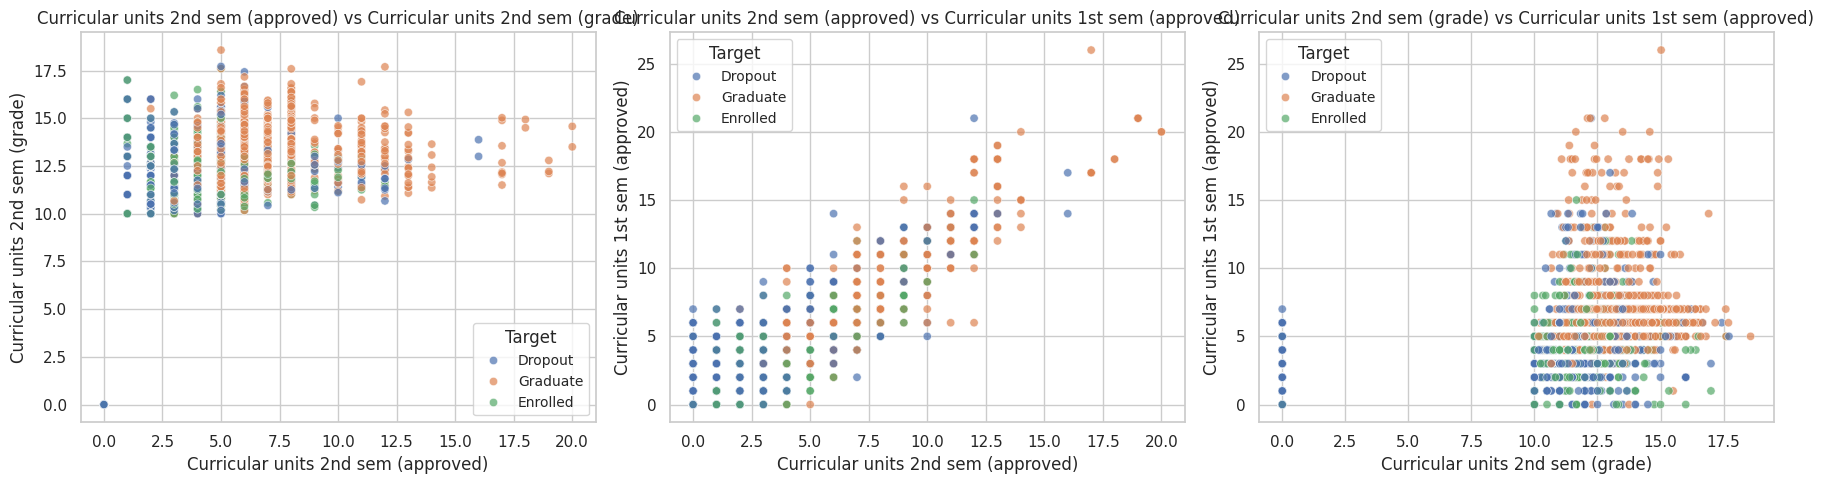

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_records = []
combined_df = selected_sample.copy()
combined_df[target_col] = df[target_col].values

for feature_x, feature_y in combinations(top_features.index, 2):
    pearson_coef = combined_df[[feature_x, feature_y]].corr(method="pearson").iloc[0, 1]
    spearman_coef = combined_df[[feature_x, feature_y]].corr(method="spearman").iloc[0, 1]
    correlation_records.append({
        "par": f"{feature_x} vs {feature_y}",
        "pearson": pearson_coef,
        "spearman": spearman_coef,
    })

correlation_df = pd.DataFrame(correlation_records)
display(correlation_df)

sns.set(style="whitegrid", context="notebook")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (feature_x, feature_y) in zip(axes, combinations(top_features.index, 2)):
    sns.scatterplot(data=combined_df, x=feature_x, y=feature_y, hue=target_col, ax=ax, alpha=0.7)
    ax.set_title(f"{feature_x} vs {feature_y}")
    ax.legend(title=target_col, loc="best", fontsize="small")

plt.tight_layout()
plt.show()

El error teórico se obtiene suponiendo que los datos siguen exactamente las distribuciones gaussianas estimadas; el error empírico refleja el desempeño sobre las observaciones reales. La comparación permite evaluar cuán bien se ajustan las hipótesis del modelo Bayesiano.

## Componentes principales a partir de la covarianza (Punto 5)

Calculamos las componentes principales usando la descomposición en valores y vectores propios de la matriz de covarianza muestral asociada a las tres características seleccionadas. Obtendremos los autovalores ordenados, los vectores propios (autovectores) normalizados y la varianza explicada acumulada.

In [55]:
eigenvalues, eigenvectors = np.linalg.eigh(sample_cov.values)
order = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[order]
sorted_eigenvectors = eigenvectors[:, order]

explained_variance_ratio = sorted_eigenvalues / sorted_eigenvalues.sum()
principal_components_df = pd.DataFrame(
    sorted_eigenvectors,
    index=sample_cov.index,
    columns=[f"PC{i+1}" for i in range(len(sorted_eigenvalues))]
)

eigen_summary = pd.DataFrame({
    "autovalor": sorted_eigenvalues,
    "varianza_explicada": explained_variance_ratio,
    "varianza_acumulada": np.cumsum(explained_variance_ratio),
}, index=[f"PC{i+1}" for i in range(len(sorted_eigenvalues))])

eigen_summary, principal_components_df

(     autovalor  varianza_explicada  varianza_acumulada
 PC1  39.392836            0.859812            0.859812
 PC2   5.598012            0.122186            0.981998
 PC3   0.824782            0.018002            1.000000,
                                           PC1       PC2       PC3
 Curricular units 2nd sem (approved) -0.431609  0.475519 -0.766547
 Curricular units 2nd sem (grade)    -0.799200 -0.595652  0.080488
 Curricular units 1st sem (approved) -0.418322  0.647364  0.637124)

## Decorrelación y whitening (Punto 6)

Proyectamos los datos centrados sobre los vectores propios para decorrelacionar (PCA sin escalado) y luego aplicamos un whitening dividiendo por la raíz cuadrada de los autovalores. Finalmente resumimos las nuevas variables con sus medias y varianzas empíricas.

In [56]:
# Datos centrados (usamos medias muestrales)
centroid = selected_sample.mean(axis=0).values
centered_data = selected_sample.values - centroid

# Matriz de vectores propios
eigvec_matrix = sorted_eigenvectors

# Decorrelación: proyección PCA
decorrelated = centered_data @ eigvec_matrix

# Whitening: dividir por sqrt de autovalores
eigvals_sqrt_inv = np.diag(1.0 / np.sqrt(sorted_eigenvalues))
whitened = decorrelated @ eigvals_sqrt_inv

decorrelated_df = pd.DataFrame(
    decorrelated,
    columns=[f"Z{i+1}" for i in range(decorrelated.shape[1])],
)
whitened_df = pd.DataFrame(
    whitened,
    columns=[f"W{i+1}" for i in range(whitened.shape[1])],
)

decorrelated_stats = decorrelated_df.agg(["mean", "var"])
whitened_stats = whitened_df.agg(["mean", "var"])

decorrelated_stats, whitened_stats

(                Z1            Z2            Z3
 mean  1.310585e-15  5.757902e-16  2.585836e-16
 var   3.939284e+01  5.598012e+00  8.247825e-01,
                 W1            W2            W3
 mean  2.136125e-16  2.469393e-16  2.931149e-16
 var   1.000000e+00  1.000000e+00  1.000000e+00)

## Clasificador bayesiano para dos clases (Punto 7)

Construimos un clasificador bayesiano óptimo suponiendo distribuciones gaussianas multivariadas para las tres características seleccionadas. Tomamos las dos clases más frecuentes (`Graduate` y `Dropout`), estimamos medias, covarianzas y probabilidades a priori, y aplicamos la regla de decisión basada en las funciones discriminantes de Bayes.

In [57]:
target_classes = df[target_col].value_counts().index[:2].tolist()
binary_df = combined_df[combined_df[target_col].isin(target_classes)].copy()
binary_df[target_col] = binary_df[target_col].astype(pd.CategoricalDtype(categories=target_classes))

X_binary = binary_df[top_features.index].values
y_binary = binary_df[target_col].values

class_params = {}
for cls in target_classes:
    cls_data = binary_df[binary_df[target_col] == cls][top_features.index].values
    mean_vec = cls_data.mean(axis=0)
    cov_mat = np.cov(cls_data, rowvar=False)
    cov_mat += np.eye(cov_mat.shape[0]) * 1e-6
    prior = len(cls_data) / len(binary_df)
    class_params[cls] = {"mean": mean_vec, "cov": cov_mat, "prior": prior}

def discriminant(x, mean, cov, prior):
    inv_cov = np.linalg.inv(cov)
    term_quad = -0.5 * ((x - mean).T @ inv_cov @ (x - mean))
    term_det = -0.5 * np.linalg.slogdet(cov)[1]
    term_prior = np.log(prior)
    return term_quad + term_det + term_prior

predictions = []
for x in X_binary:
    scores = {cls: discriminant(x, params["mean"], params["cov"], params["prior"]) for cls, params in class_params.items()}
    predictions.append(max(scores, key=scores.get))

predictions = np.array(predictions)

conf_matrix = pd.crosstab(pd.Series(y_binary, name="Real"), pd.Series(predictions, name="Predicho"))
accuracy = (predictions == y_binary).mean()

params_table = pd.DataFrame({
    cls: {
        "prior": class_params[cls]["prior"],
        **{f"mean_{feat}": val for feat, val in zip(top_features.index, class_params[cls]["mean"])}
    }
    for cls in target_classes
}).T

params_table, conf_matrix, accuracy

(            prior  mean_Curricular units 2nd sem (approved)  \
 Graduate  0.60854                                  6.177003   
 Dropout   0.39146                                  1.940183   
 
           mean_Curricular units 2nd sem (grade)  \
 Graduate                              12.697276   
 Dropout                                5.899339   
 
           mean_Curricular units 1st sem (approved)  
 Graduate                                  6.232232  
 Dropout                                   2.551724  ,
 Predicho  Dropout  Graduate
 Real                       
 Graduate      120      2089
 Dropout       898       523,
 np.float64(0.8228650137741047))

## Superficie de decisión en 3D (Punto 8)

Representamos la superficie de decisión del clasificador bayesiano usando las dos características con mayor varianza (derivadas de los autovalores). Se evalúa la diferencia entre los discriminantes $g_1$ y $g_2$ en una rejilla y se visualiza junto a los datos.


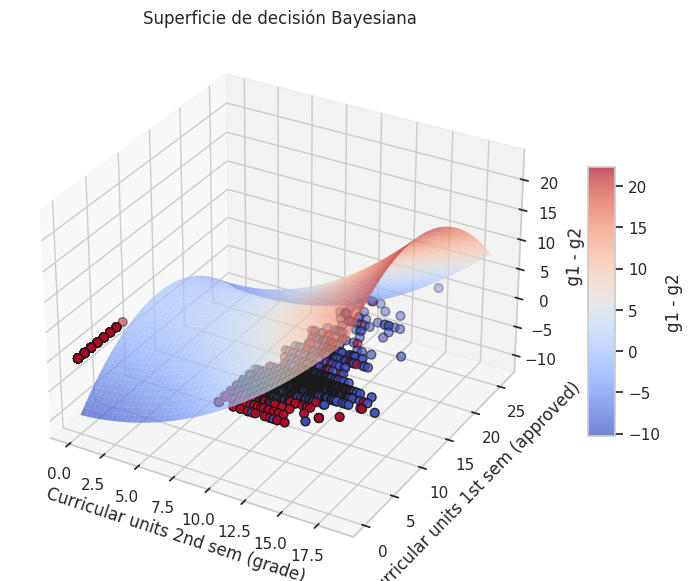

In [58]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

top_two_features = selected_sample.var().sort_values(ascending=False).index[:2]

f1, f2 = top_two_features
cls1, cls2 = target_classes
params1 = class_params[cls1]
params2 = class_params[cls2]

grid_x = np.linspace(selected_sample[f1].min(), selected_sample[f1].max(), 100)
grid_y = np.linspace(selected_sample[f2].min(), selected_sample[f2].max(), 100)
xx, yy = np.meshgrid(grid_x, grid_y)

mean1 = params1["mean"][:2]
mean2 = params2["mean"][:2]
cov1 = params1["cov"][:2, :2]
cov2 = params2["cov"][:2, :2]

def discriminant_2d(point, mean, cov, prior):
    inv_cov = np.linalg.inv(cov)
    diff = point - mean
    term_quad = -0.5 * diff.T @ inv_cov @ diff
    term_det = -0.5 * np.linalg.slogdet(cov)[1]
    term_prior = np.log(prior)
    return term_quad + term_det + term_prior

points = np.c_[xx.ravel(), yy.ravel()]

g_diff = []
for point in points:
    g1 = discriminant_2d(point, mean1, cov1, params1["prior"])
    g2 = discriminant_2d(point, mean2, cov2, params2["prior"])
    g_diff.append(g1 - g2)

g_diff = np.array(g_diff).reshape(xx.shape)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(xx, yy, g_diff, cmap="coolwarm", alpha=0.7, linewidth=0, antialiased=True)

scatter = ax.scatter(
    binary_df[f1],
    binary_df[f2],
    np.zeros_like(binary_df[f1]),
    c=pd.Categorical(binary_df[target_col]).codes,
    cmap="coolwarm",
    edgecolor="k",
    s=40,
)

ax.set_xlabel(f1)
ax.set_ylabel(f2)
ax.set_zlabel("g1 - g2")
ax.set_title("Superficie de decisión Bayesiana")

fig.colorbar(surf, shrink=0.5, aspect=10, label="g1 - g2")
plt.show()


La superficie representa $g_1 - g_2$; la frontera de decisión se encuentra donde la superficie cruza el plano cero. Los puntos Azul/Rojo muestran las observaciones de cada clase proyectadas en las dos variables más influyentes.


La tabla de parámetros resume los valores medios y probabilidades a priori por clase. La matriz de confusión y la exactitud indican el desempeño del clasificador bayesiano. La regla óptima adjudica cada nuevo vector $x$ a la clase cuyo discriminante $g_i(x)$ (calculado con la media, covarianza y prior estimados) sea mayor.

Las tablas reportan media y varianza muestral de las variables decorrelacionadas `Z` y de las variables blanqueadas `W`. Tras el whitening, las varianzas están cercanas a 1 y las covarianzas se reducen a cero, como se espera de un procedimiento de esferización.

La primera tabla enumera los autovalores y la fracción de varianza que explica cada componente principal. La segunda muestra los vectores propios asociados (direcciones de máxima varianza) expresados como combinaciones lineales de las características originales.

La tabla muestra los coeficientes de correlación lineal (Pearson) y monotónica (Spearman) para cada par. Las gráficas de dispersión permiten visualizar la estructura de los datos y cómo se separan las clases del `Target` en cada combinación de variables.

Interpretamos independencia cuando ninguna de las pruebas detecta dependencia significativa (valor-p >= 0.05). Si la chi-cuadrado o Spearman generan valores-p bajos, concluimos dependencia desde la perspectiva respectiva. Esto complementa el análisis de covarianzas observando posibles relaciones no lineales.

La primera tabla resume media y varianza teórica de cada variable. La matriz diagonal corresponde a la covarianza teórica bajo independencia, mientras que la segunda matriz muestra la covarianza muestral calculada sobre los datos imputados. La matriz de diferencias evidencia qué tan lejos está la covarianza empírica de la teórica.

Los resultados permiten comparar la distribución ajustada de cada variable y evaluar cómo difieren las covarianzas empíricas respecto a las teóricas bajo independencia. Estas discrepancias orientan el análisis posterior sobre dependencia y correlación entre las características seleccionadas.

## Probabilidad de error teórica y verificación (Punto 9)

Estimamos la probabilidad de error teórica del clasificador Bayesiano simulando muestras desde las distribuciones gaussianas ajustadas para cada clase (usando los parámetros calculados). Luego comparamos este valor con el error empírico obtenido sobre los datos reales.

In [59]:
def classify_point(x):
    scores = {cls: discriminant(x, params["mean"], params["cov"], params["prior"]) for cls, params in class_params.items()}
    return max(scores, key=scores.get)

simulations = {}
simulated_predictions = []
simulated_true = []

samples_per_class = 50000
rng = np.random.default_rng(42)
for cls, params in class_params.items():
    draws = rng.multivariate_normal(params["mean"], params["cov"], size=samples_per_class)
    sims_cls = [classify_point(x) for x in draws]
    simulated_predictions.extend(sims_cls)
    simulated_true.extend([cls] * samples_per_class)
    simulations[cls] = draws

simulated_predictions = np.array(simulated_predictions)
simulated_true = np.array(simulated_true)

theoretical_error = (simulated_predictions != simulated_true).mean()
empirical_error = 1 - accuracy

theoretical_error, empirical_error

(np.float64(0.15669), np.float64(0.1771349862258953))